In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define column names based on the user's description
column_names = ['X', 'Y', 'Z', 'Roll', 'Pitch', 'Yaw']

             X         Y         Z      Roll     Pitch       Yaw
0     0.073232  0.024992  0.169241 -0.008604 -0.004437 -0.060112
1     0.073236  0.024993  0.169250 -0.008652 -0.004524 -0.060002
2     0.073238  0.025006  0.169244 -0.008655 -0.004423 -0.060059
3     0.073226  0.025002  0.169246 -0.008716 -0.004221 -0.059988
4     0.073227  0.024982  0.169256 -0.008915 -0.004124 -0.059794
...        ...       ...       ...       ...       ...       ...
8120  0.057906  0.007280  0.170891  0.004559 -0.010916  0.016897
8121  0.057903  0.007307  0.170873  0.004795 -0.011008  0.016750
8122  0.057902  0.007283  0.170866  0.004549 -0.010989  0.016822
8123  0.057907  0.007274  0.170883  0.004498 -0.010900  0.017006
8124  0.057914  0.007270  0.170875  0.004416 -0.010990  0.017074

[8125 rows x 6 columns]


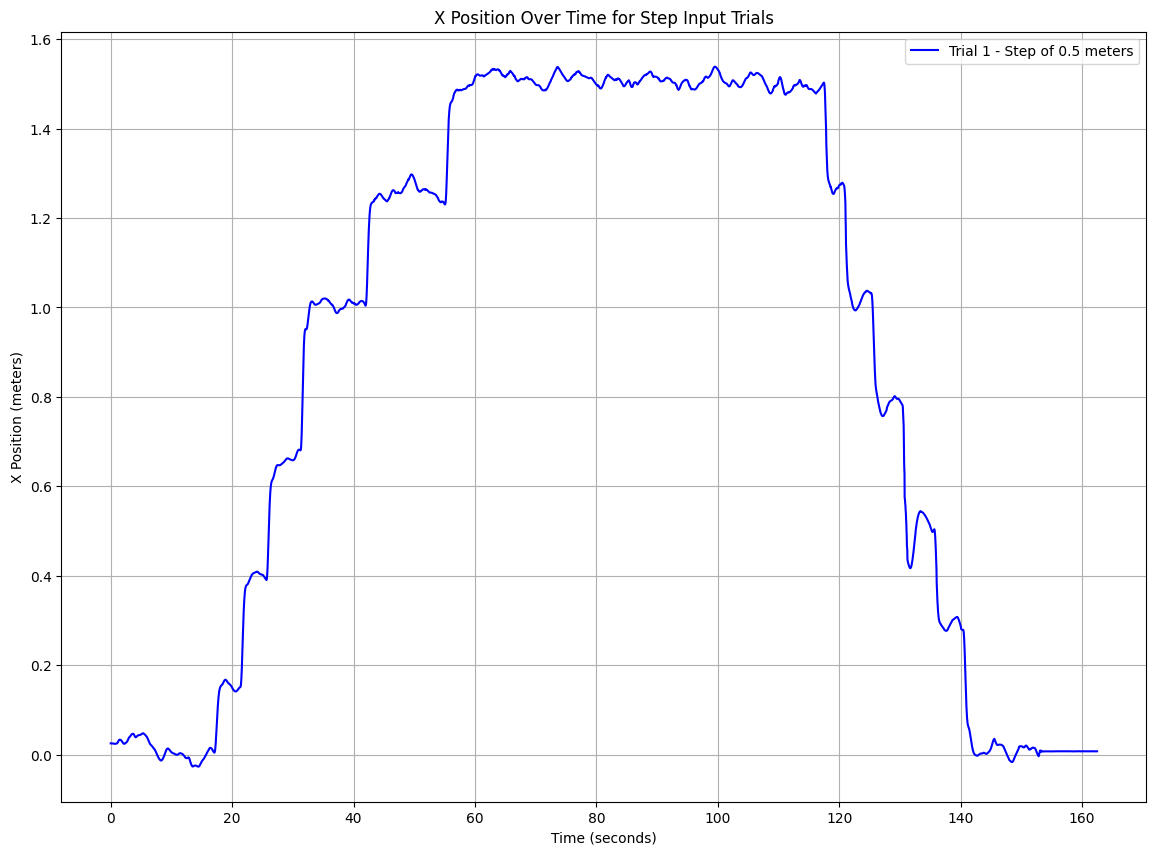

In [32]:
# Step analysis 

trans3_step_data = pd.read_csv('camera_data2.csv', header=None, names=column_names)

hz = 50
print(trans3_step_data)
# Assuming each row corresponds to 1/50th of a second, create a time column for the first dataset
trans3_step_data['Time'] = trans3_step_data.index / hz  # Dataset was collected at 50 Hz
trans3_step_data_filtered = trans3_step_data

# Read the new simulation data
sim_data = pd.read_csv('time_series_data_sim.csv', names=['Time', 'X'])
sim_data = sim_data[sim_data['Time'] <= 4.239999999999998]


# Plot X against time for both trials
plt.figure(figsize=(14, 10))
plt.plot(trans3_step_data_filtered['Time'], trans3_step_data_filtered['Y'], label='Trial 1 - Step of 0.5 meters', color='blue')
plt.title('X Position Over Time for Step Input Trials')
plt.xlabel('Time (seconds)')
plt.ylabel('X Position (meters)')
plt.grid(True)
plt.legend()
plt.show()

/var/folders/xk/pfn3rnq979d0c6p3d9k2w2q80000gn/T/ipykernel_15467/4163063870.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  trans3_step_data_filtered = trans3_step_data_filtered[trans3_step_data['Time'] >= 15]


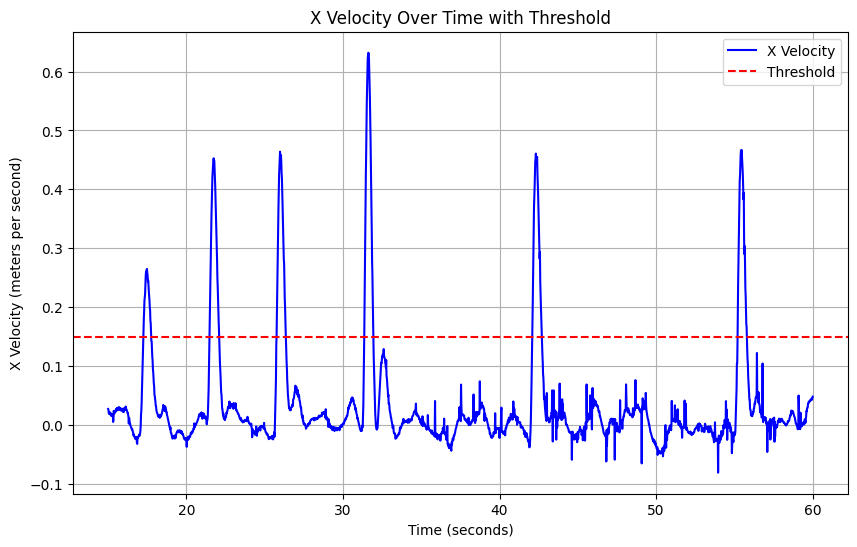

(0.15, 12)

In [33]:
# Adjusting the approach to account for the nature of the step responses as curves
# This time, we aim for more than 10 intersections as a stop condition, indicating we've captured the 5 step inputs

# Reinitialize the starting threshold and conditions
threshold = 0.15
threshold_decrement = 0.005
intersections_found = 0
trans3_step_data['Y_derivative'] = trans3_step_data['Y'].diff() / trans3_step_data['Time'].diff()
trans3_step_data_filtered = trans3_step_data[trans3_step_data['Time'] <= 60]
trans3_step_data_filtered = trans3_step_data_filtered[trans3_step_data['Time'] >= 15]

# Reset analysis to start with the highest threshold and move downwards
while threshold > 0:
    # Count the number of times the derivative crosses the threshold, indicating intersections
    # This is done by checking where the derivative goes from below to above the threshold or vice versa
    crosses_threshold = ((trans3_step_data_filtered['Y_derivative'] > threshold) & 
                         (trans3_step_data_filtered['Y_derivative'].shift(1) < threshold)) | \
                        ((trans3_step_data_filtered['Y_derivative'] < threshold) & 
                         (trans3_step_data_filtered['Y_derivative'].shift(1) > threshold))
    
    intersections_found = crosses_threshold.sum()
    
    # Stop condition: If more than 10 intersections, we likely have captured the 5 steps
    if intersections_found > 10:
        break
    else:
        # If not, decrease the threshold and try again
        threshold -= threshold_decrement

# Plot the derivative with the final threshold line to visualize the intersections
plt.figure(figsize=(10, 6))
plt.plot(trans3_step_data_filtered['Time'], trans3_step_data_filtered['Y_derivative'], label='X Velocity', color='blue')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
plt.title('X Velocity Over Time with Threshold')
plt.xlabel('Time (seconds)')
plt.ylabel('X Velocity (meters per second)')
plt.grid(True)
plt.legend()
plt.show()

threshold, intersections_found

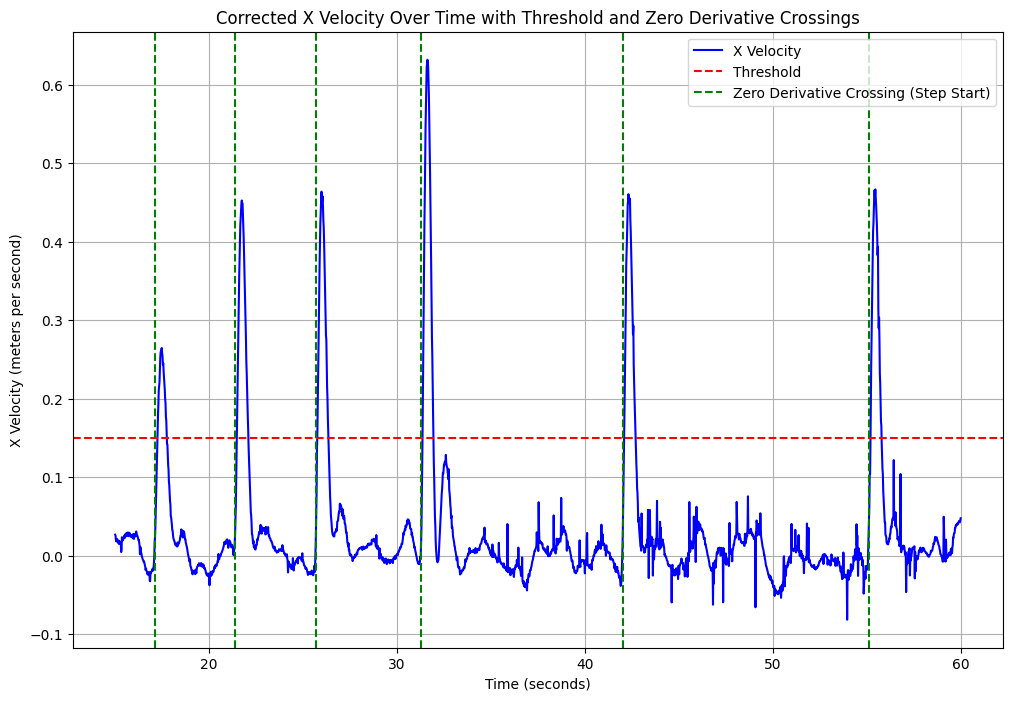

[17.14, 21.38, 25.68, 31.3, 42.02, 55.1]

In [34]:
# Correcting the approach based on the new explanation
# Starting at each threshold crossing point, move back in time until the derivative crosses zero
cross_points = trans3_step_data_filtered[crosses_threshold]['Time']
# Initialize a list to store the corrected time points for when the derivative first crosses zero moving back from each threshold point
corrected_zero_derivative_times = []

for cross_time in cross_points:
    # Filter the dataset to consider only points before the current crossing point
    before_cross = trans3_step_data_filtered[trans3_step_data_filtered['Time'] <= cross_time]
    
    # Find the first point moving back in time where the derivative crosses zero
    zero_crossings = before_cross[before_cross['Y_derivative'] * before_cross['Y_derivative'].shift(1) < 0.001]
    
    if not zero_crossings.empty:
        zero_derivative_time = zero_crossings.iloc[-1]['Time']  # The last crossing point before the threshold crossing
        corrected_zero_derivative_times.append(zero_derivative_time)

# Remove potential duplicates due to very close zero crossings by converting to set and back to list
corrected_zero_derivative_times = list(set(corrected_zero_derivative_times))

# Sort the list to maintain chronological order
corrected_zero_derivative_times.sort()

# Plot the derivative graph again, this time highlighting the corrected zero derivative points
plt.figure(figsize=(12, 8))
plt.plot(trans3_step_data_filtered['Time'], trans3_step_data_filtered['Y_derivative'], label='X Velocity', color='blue')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')

# Highlight corrected zero derivative points
for zero_time in corrected_zero_derivative_times:
    plt.axvline(x=zero_time, color='green', linestyle='--', label='Zero Derivative Crossing (Step Start)' if corrected_zero_derivative_times.index(zero_time) == 0 else "")

plt.title('Corrected X Velocity Over Time with Threshold and Zero Derivative Crossings')
plt.xlabel('Time (seconds)')
plt.ylabel('X Velocity (meters per second)')
plt.grid(True)
plt.legend()
plt.show()

corrected_zero_derivative_times


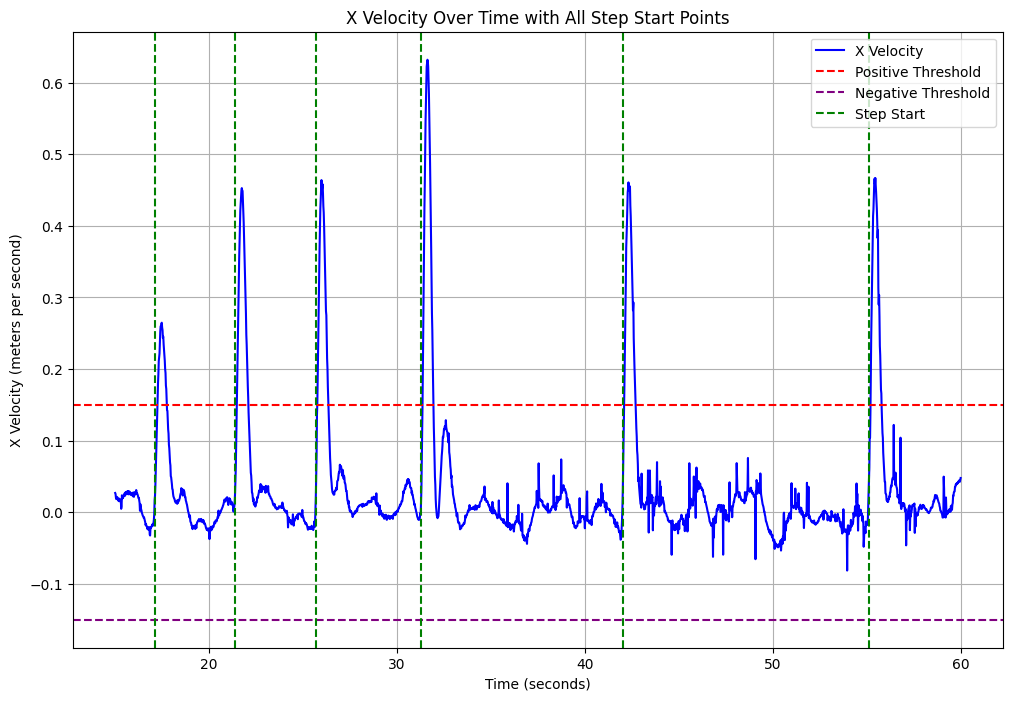

[17.14, 21.38, 25.68, 31.3, 42.02, 55.1]

In [35]:
# To find the starting points for all step commands, including those from 0.25 m back to 0 m,
# we will adjust our analysis to consider both positive and negative threshold crossings.

# Initialize a list to store the time points for both positive and negative step commands
all_step_start_times = []

# Define a function to find zero crossings for given conditions
def find_zero_crossings(data, threshold, direction='positive'):
    if direction == 'positive':
        crosses_threshold = ((data['Y_derivative'] > threshold) & 
                             (data['Y_derivative'].shift(1) <= threshold)) | \
                            ((data['Y_derivative'] < -threshold) & 
                             (data['Y_derivative'].shift(1) >= -threshold))
    else:
        crosses_threshold = ((data['Y_derivative'] < threshold) & 
                             (data['Y_derivative'].shift(1) >= threshold)) | \
                            ((data['Y_derivative'] > -threshold) & 
                             (data['Y_derivative'].shift(1) <= -threshold))
        
    cross_points = data[crosses_threshold]['Time']
    zero_crossings = []

    for cross_time in cross_points:
        # Filter the dataset to consider only points before the current crossing point
        before_cross = data[data['Time'] <= cross_time]

        # Find the first point moving back in time where the derivative crosses zero
        zero_cross_indices = before_cross.index[before_cross['Y_derivative'] * before_cross['Y_derivative'].shift(1) < 0.001]
        if not zero_cross_indices.empty:
            zero_derivative_time = before_cross.loc[zero_cross_indices[-1], 'Time']  # The last crossing point before the threshold crossing
            zero_crossings.append(zero_derivative_time)

    return zero_crossings

# Analyze for positive step commands (0 to 0.25 m)
positive_zero_crossings = find_zero_crossings(trans3_step_data_filtered, threshold, 'positive')
all_step_start_times.extend(positive_zero_crossings)

# Analyze for negative step commands (0.25 to 0 m)
negative_zero_crossings = find_zero_crossings(trans3_step_data_filtered, threshold, 'negative')
all_step_start_times.extend(negative_zero_crossings)

# Remove potential duplicates and sort the list to maintain chronological order
all_step_start_times = list(set(all_step_start_times))
all_step_start_times.sort()

# Plot the derivative graph again, highlighting all discovered points
plt.figure(figsize=(12, 8))
plt.plot(trans3_step_data_filtered['Time'], trans3_step_data_filtered['Y_derivative'], label='X Velocity', color='blue')
plt.axhline(y=threshold, color='red', linestyle='--', label='Positive Threshold')
plt.axhline(y=-threshold, color='purple', linestyle='--', label='Negative Threshold')

# Highlight all step start points
for start_time in all_step_start_times:
    plt.axvline(x=start_time, color='green', linestyle='--', label='Step Start' if all_step_start_times.index(start_time) == 0 else "")

plt.title('X Velocity Over Time with All Step Start Points')
plt.xlabel('Time (seconds)')
plt.ylabel('X Velocity (meters per second)')
plt.grid(True)
plt.legend()
plt.show()

all_step_start_times

[4.239999999999998, 4.300000000000001, 5.620000000000001, 10.720000000000002, 13.079999999999998]
4.239999999999998
4.300000000000001
5.620000000000001
10.720000000000002
13.079999999999998
13.079999999999998


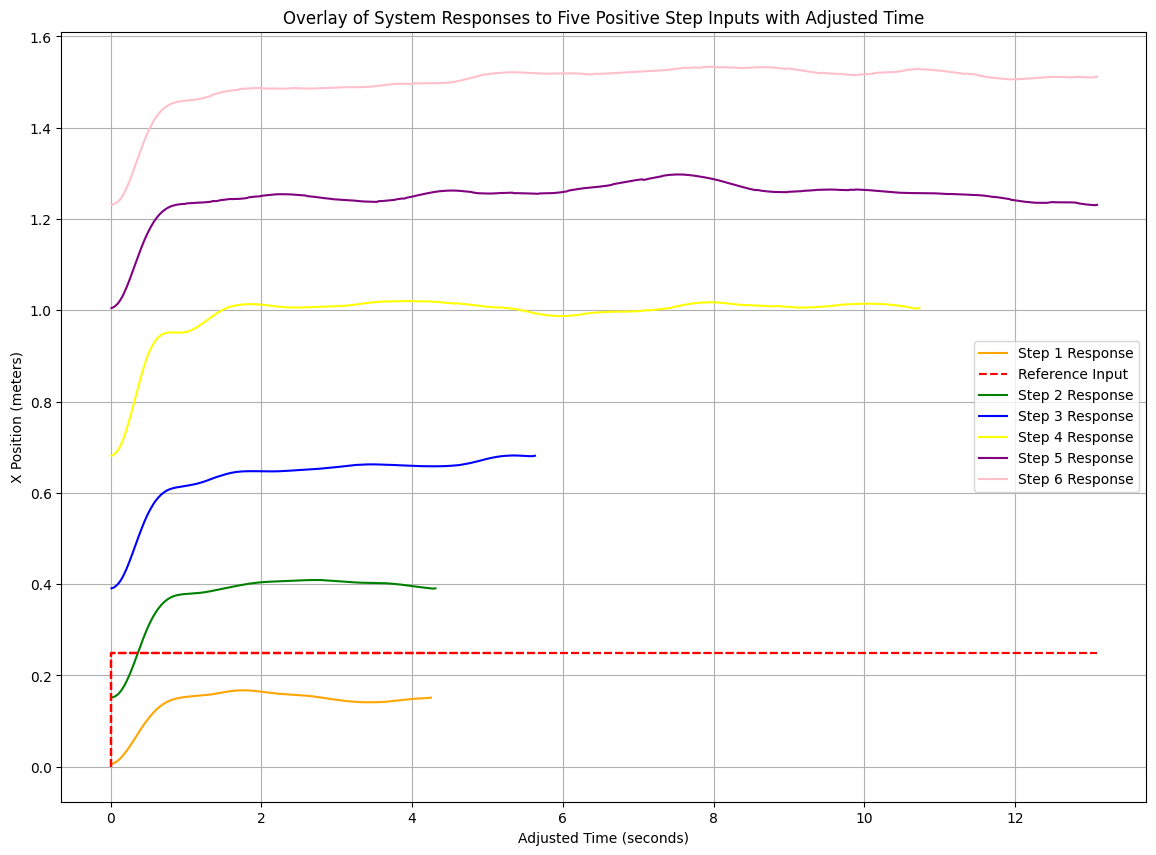

In [36]:
# Implementing the feedback correctly this time by alternating between positive and negative steps for accurate intervals.

plt.figure(figsize=(14, 10))

time_offset = 0.01

colors = ['orange', 'green', 'blue', 'yellow', 'purple', 'pink']
# Calculate the interval for plotting based on the difference between the start of a positive step and the subsequent negative step
intervals = [all_step_start_times[i + 1] - all_step_start_times[i] for i in range(0, 5, 1)]
print(intervals)


# Plot each positive step with its correctly calculated interval
for i, step_start_time in enumerate(all_step_start_times):  # Select every other time starting with the first, for positive steps
    observation_duration = intervals[i] if i < len(intervals) else intervals[-1]  # Use the last known interval for the last step if necessary
    
    print(observation_duration)
    # Adjust each step's time data to start from the new t=0.01
    plot_data = trans3_step_data[(trans3_step_data['Time'] >= step_start_time) & (trans3_step_data['Time'] <= step_start_time + observation_duration)]
    plot_data_adjusted = plot_data.copy()
    plot_data_adjusted['Time'] = plot_data['Time'] - step_start_time + time_offset  # Shift time to start near zero
    
    # Plot the adjusted system response for each step
    plt.plot(plot_data_adjusted['Time'], plot_data_adjusted['Y'], label=f'Step {i+1} Response', color=colors[i])
    
    # Adjust the reference signal for the step input, creating a modified L shape with an initial rise
    ref_signal_time = [0, time_offset, time_offset + observation_duration]  # Start just before the new t=0 to show the rise
    ref_signal_x = [0, 0.25, 0.25]  # Maintain at 0.25 meters
    
    # Plot the reference signal
    plt.step(ref_signal_time, ref_signal_x, where='post', color='red', linestyle='--', label='Reference Input' if i == 0 else f"_nolegend_")

plt.title('Overlay of System Responses to Five Positive Step Inputs with Adjusted Time')
plt.xlabel('Adjusted Time (seconds)')
plt.ylabel('X Position (meters)')
plt.grid(True)
plt.legend()
plt.show()

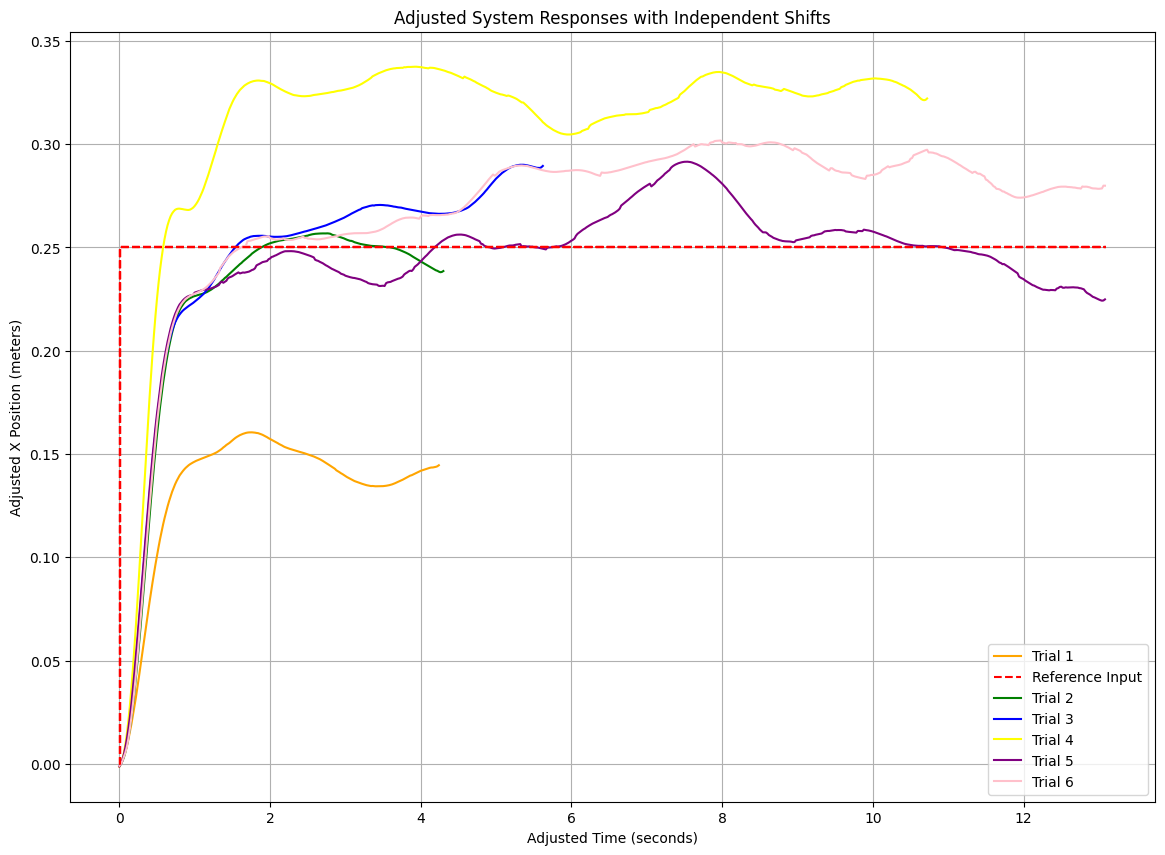

In [37]:
# Initialize a list to store adjusted datasets for each trial
adjusted_datasets = []
shifts = []
# Calculate and apply the shift for each trial
for i, step_start_time in enumerate(all_step_start_times):
    # Identify the trial data and its start point
    observation_duration = intervals[i] if i < len(intervals) else intervals[-1]
    trial_data = trans3_step_data[(trans3_step_data['Time'] >= step_start_time) & 
                                  (trans3_step_data['Time'] <= step_start_time + observation_duration)]
    
    # Calculate the shift needed to start at X=0, using the first X position at or after t=0.01 seconds
    initial_x_at_001 = trial_data[trial_data['Time'] >= step_start_time + 0.01]['Y'].iloc[0]
    shift = -initial_x_at_001
    shifts.append(shift)
    
    # Apply the shift
    adjusted_data = trial_data.copy()
    adjusted_data['Y'] = adjusted_data['Y'] + shift
    
    
    # Adjust the time to start from 0 for plotting
    adjusted_data['Adjusted Time'] = adjusted_data['Time'] - step_start_time
    
    adjusted_datasets.append(adjusted_data)

reference_input = 0.25
# Plot the adjusted X positions over time for each trial
plt.figure(figsize=(14, 10))
for i, adjusted_data in enumerate(adjusted_datasets):
    plt.plot(adjusted_data['Adjusted Time'], adjusted_data['Y'], label=f'Trial {i+1}', color=colors[i])
    plt.step(ref_signal_time, ref_signal_x, where='post', color='red', linestyle='--', label='Reference Input' if i == 0 else f"_nolegend_")
    
    

plt.title('Adjusted System Responses with Independent Shifts')
plt.xlabel('Adjusted Time (seconds)')
plt.ylabel('Adjusted X Position (meters)')
plt.grid(True)
plt.legend()
plt.show()


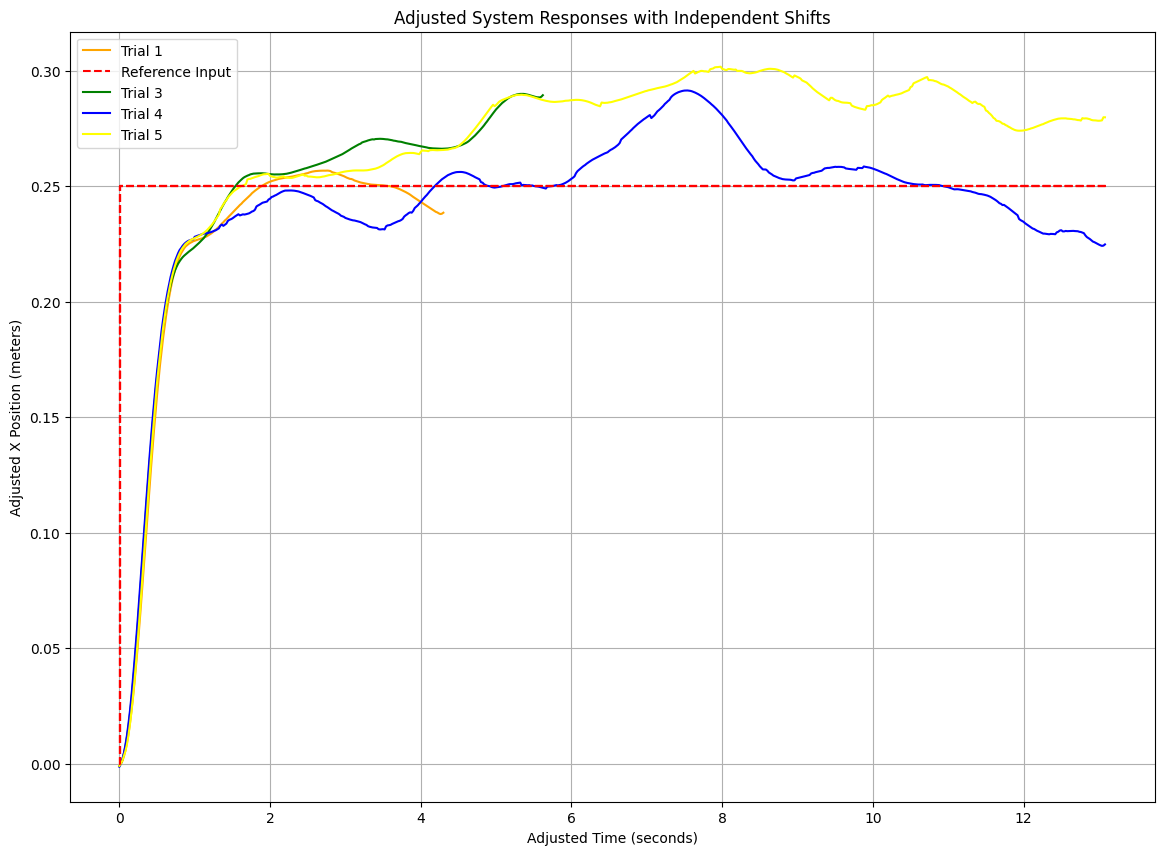

In [38]:
# Initialize a list to store adjusted datasets for each trial
adjusted_datasets = []
shifts = []
# Calculate and apply the shift for each trial
for i, step_start_time in enumerate(all_step_start_times):
    # Skip trials 4 and 1
    if i == 3 or i == 0:
        continue
    
    # Identify the trial data and its start point
    observation_duration = intervals[i] if i < len(intervals) else intervals[-1]
    trial_data = trans3_step_data[(trans3_step_data['Time'] >= step_start_time) & 
                                  (trans3_step_data['Time'] <= step_start_time + observation_duration)]
    
    # Calculate the shift needed to start at X=0, using the first X position at or after t=0.01 seconds
    initial_x_at_001 = trial_data[trial_data['Time'] >= step_start_time + 0.01]['Y'].iloc[0]
    shift = -initial_x_at_001
    shifts.append(shift)
    
    # Apply the shift
    adjusted_data = trial_data.copy()
    adjusted_data['Y'] = adjusted_data['Y'] + shift
    
    # Adjust the time to start from 0 for plotting
    adjusted_data['Adjusted Time'] = adjusted_data['Time'] - step_start_time
    
    adjusted_datasets.append(adjusted_data)

reference_input = 0.25
# Plot the adjusted X positions over time for each trial
plt.figure(figsize=(14, 10))
for i, adjusted_data in enumerate(adjusted_datasets):
    # Adjust the trial number for labeling, skipping trials 4 and 1
    trial_number = i + 2 if i >= 1 else i + 1
    plt.plot(adjusted_data['Adjusted Time'], adjusted_data['Y'], label=f'Trial {trial_number}', color=colors[i])
    plt.step(ref_signal_time, ref_signal_x, where='post', color='red', linestyle='--', label='Reference Input' if i == 0 else f"_nolegend_")
    
plt.title('Adjusted System Responses with Independent Shifts')
plt.xlabel('Adjusted Time (seconds)')
plt.ylabel('Adjusted X Position (meters)')
plt.grid(True)
plt.legend()
plt.show()


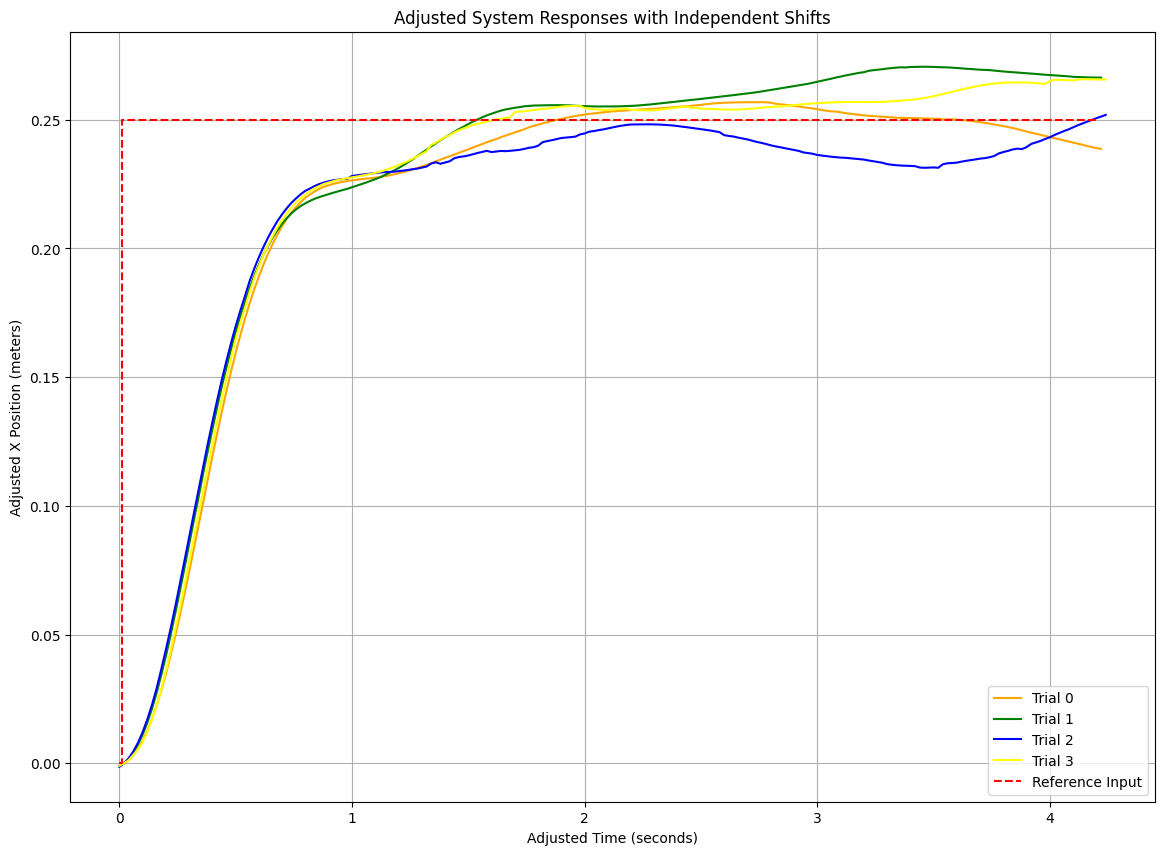

In [39]:
# Initialize a list to store adjusted datasets for each trial
adjusted_datasets = []
shifts = []

# Find the shortest interval
shortest_interval = min(intervals)

# Calculate and apply the shift for each trial
for i, step_start_time in enumerate(all_step_start_times):
    # Skip trials 4 and 1
    if i == 3 or i == 0:
        continue
    
    # Identify the trial data using the shortest interval
    trial_data = trans3_step_data[(trans3_step_data['Time'] >= step_start_time) & 
                                  (trans3_step_data['Time'] <= step_start_time + shortest_interval)]
    
    # Calculate the shift needed to start at X=0, using the first X position at or after t=0.01 seconds
    initial_x_at_001 = trial_data[trial_data['Time'] >= step_start_time + 0.01]['Y'].iloc[0]
    shift = -initial_x_at_001
    shifts.append(shift)
    
    # Apply the shift
    adjusted_data = trial_data.copy()
    adjusted_data['Y'] = adjusted_data['Y'] + shift
    
    # Adjust the time to start from 0 for plotting
    adjusted_data['Adjusted Time'] = adjusted_data['Time'] - step_start_time
    
    adjusted_datasets.append(adjusted_data)

reference_input = 0.25
# Plot the adjusted X positions over time for each trial
plt.figure(figsize=(14, 10))
for i, adjusted_data in enumerate(adjusted_datasets):
    # Adjust the trial number for labeling, skipping trials 4 and 1
    trial_number = i + 2 if i >= 1 else i + 1
    plt.plot(adjusted_data['Adjusted Time'], adjusted_data['Y'], label=f'Trial {i}', color=colors[i])
    
plt.step([0, 0.01, 4.2], ref_signal_x, where='post', color='red', linestyle='--', label='Reference Input')
plt.title('Adjusted System Responses with Independent Shifts')
plt.xlabel('Adjusted Time (seconds)')
plt.ylabel('Adjusted X Position (meters)')
plt.grid(True)
plt.legend()
plt.show()


In [40]:
# Initialize an empty DataFrame with columns for common time and each trial
column_names = ['Common Time']
combined_data = pd.DataFrame(columns=column_names)

# Define the indices of the specific trials you want to capture
selected_trials = [1, 2, 4, 5]  # Adjust these indices as needed

# Find the shortest interval
shortest_interval = min(intervals)

# Iterate over the selected trials and merge the data into the combined DataFrame
for i, t in enumerate(selected_trials):
    step_start_time = all_step_start_times[t]
    trial_data = trans3_step_data[(trans3_step_data['Time'] >= step_start_time) & 
                                  (trans3_step_data['Time'] <= step_start_time + shortest_interval)]
    trial_data_adjusted = trial_data.copy()
    trial_data_adjusted['Y'] = trial_data_adjusted['Y'] + shifts[i]  # Apply the shift
    trial_data_adjusted['Common Time'] = trial_data['Time'] - step_start_time
    
    # Merge the trial data into the combined DataFrame
    combined_data = pd.merge(combined_data, trial_data_adjusted[['Common Time', 'Y']], on='Common Time', how='outer', sort=True)
    combined_data = combined_data.rename(columns={'Y': f'Trial {t+1}'})

# Fill any missing values with NaN or interpolate if desired
combined_data = combined_data.fillna(method='ffill')

combined_data.head()


,Common Time,Trial 2,Trial 3,Trial 5,Trial 6
0,0.00,-0.000896,-0.001075,-0.001305,-0.000929
1,0.02,-0.000896,-0.001075,0.000000,0.000000
2,0.02,0.000000,0.000000,0.000000,0.000000
3,0.04,0.000000,0.001594,0.001962,0.001245
4,0.04,0.001240,0.001594,0.001962,0.001245


In [41]:
import control

step_info_list = []
x_values = combined_data['Trial 2'].values
time_values = combined_data['Common Time'].values
step_info = control.step_info(x_values, T=time_values, SettlingTimeThreshold=0.05, yfinal=0.25)
step_info['Title'] = 'Step Analysis of Trial 1'
step_info_list.append(step_info)

print(step_info)
x_values = combined_data['Trial 3'].values
time_values = combined_data['Common Time'].values
step_info = control.step_info(x_values, T=time_values, SettlingTimeThreshold=0.05, yfinal=0.25)
step_info['Title'] = 'Step Analysis of  Trial 2'
step_info_list.append(step_info)

print(step_info)
x_values = combined_data['Trial 5'].values
time_values = combined_data['Common Time'].values
step_info = control.step_info(x_values, T=time_values, SettlingTimeThreshold=0.05, yfinal=0.25)
step_info['Title'] = 'Step Analysis of Trial 3'
step_info_list.append(step_info)

print(step_info)
x_values = combined_data['Trial 6'].values
time_values = combined_data['Common Time'].values
step_info = control.step_info(x_values, T=time_values, SettlingTimeThreshold=0.05, yfinal=0.25)
step_info['Title'] = 'Step Analysis of  Trial 4'
step_info_list.append(step_info)



{'RiseTime': 0.740000000000002, 'SettlingTime': 1.4800000000000004, 'SettlingMin': 0.225066086219199, 'SettlingMax': 0.25680629627310403, 'Overshoot': 2.7225185092416115, 'Undershoot': 0.35856111785919076, 'Peak': 0.25680629627310403, 'PeakTime': 2.7600000000000016, 'SteadyStateValue': 0.25, 'Title': 'Step Analysis of Trial 1'}
{'RiseTime': 0.8999999999999986, 'SettlingTime': nan, 'SettlingMin': 0.22554883380878799, 'SettlingMax': 0.27056124358633804, 'Overshoot': 8.224497434535216, 'Undershoot': 0.4298205841931857, 'Peak': 0.27056124358633804, 'PeakTime': 3.460000000000001, 'SteadyStateValue': 0.25, 'Title': 'Step Analysis of  Trial 2'}
{'RiseTime': 0.7199999999999989, 'SettlingTime': 3.8200000000000003, 'SettlingMin': 0.2255972963605899, 'SettlingMax': 0.2518392681887198, 'Overshoot': 0.735707275487929, 'Undershoot': 0.5220693393479969, 'Peak': 0.2518392681887198, 'PeakTime': 4.239999999999995, 'SteadyStateValue': 0.25, 'Title': 'Step Analysis of Trial 3'}


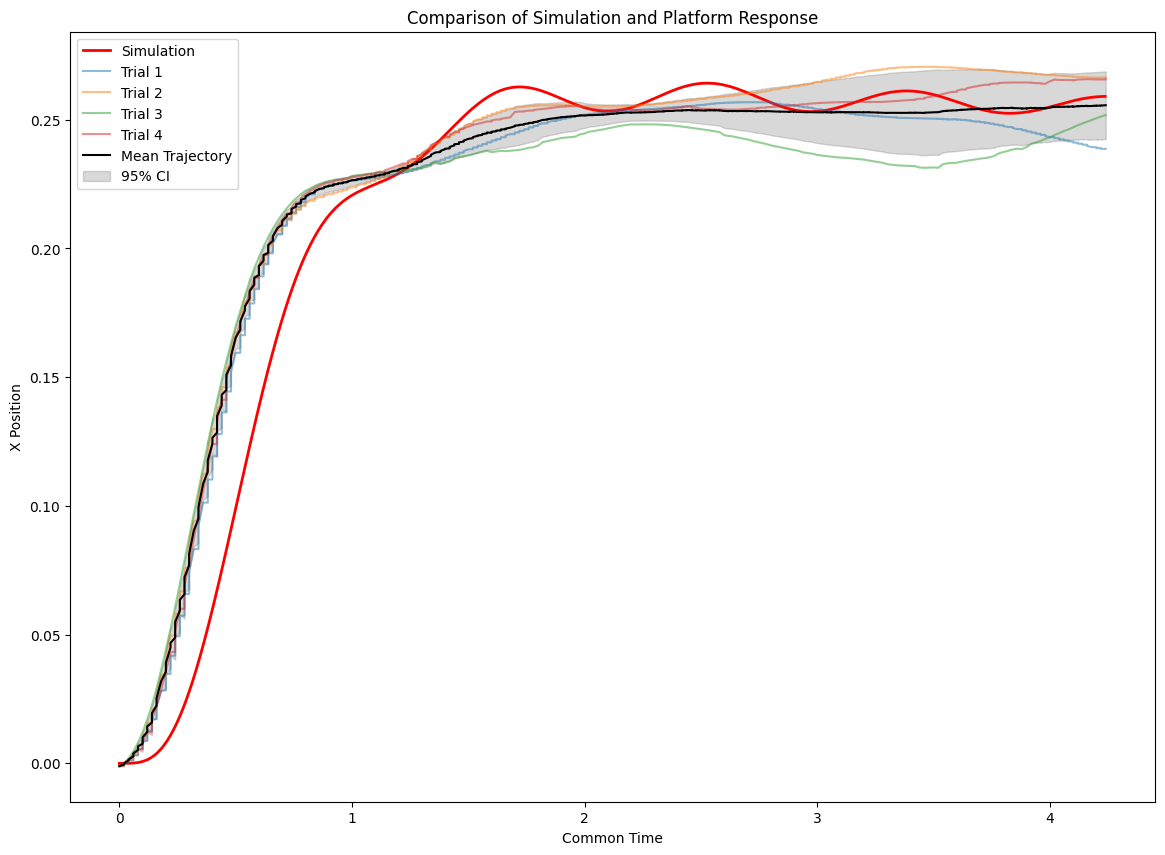

In [44]:
# Calculate the mean and standard deviation across trials at each time step
combined_data['Mean'] = combined_data[['Trial 2', 'Trial 3', 'Trial 5', 'Trial 6']].mean(axis=1)
combined_data['Std'] = combined_data[['Trial 2', 'Trial 3', 'Trial 5', 'Trial 6']].std(axis=1)

# Plot the individual trajectories
plt.figure(figsize=(14, 10))

plt.plot(sim_data['Time'], sim_data['X'], label='Simulation', color='red', linewidth=2)


for i, t in enumerate(selected_trials):
    plt.plot(combined_data['Common Time'], combined_data[f'Trial {t+1}'], label=f'Trial {i+1}', alpha=0.5)

# Plot the mean trajectory
plt.plot(combined_data['Common Time'], combined_data['Mean'], label='Mean Trajectory', color='black')

# Plot the confidence interval
plt.fill_between(combined_data['Common Time'], 
                 combined_data['Mean'] - combined_data['Std'], 
                 combined_data['Mean'] + combined_data['Std'], 
                 alpha=0.3, color='gray', label='95% CI')


plt.xlabel('Common Time')
plt.ylabel('X Position')
plt.title('Comparison of Simulation and Platform Response')
plt.legend()
plt.show()


In [43]:
# Assuming 'combined_data' is your DataFrame with 'Mean' as the mean signal and 'Common Time' as the time vector
mean_signal = combined_data['Mean'].values  # The mean signal as a 1D numpy array
time = combined_data['Common Time'].values  # The corresponding time vector as a 1D numpy array

# Calculate step response characteristics for the mean signal, now providing both the signal and its time vector
step_info = control.step_info(mean_signal, T=time, SettlingTimeThreshold=0.05, yfinal=0.25)

# Scenario 1: Mean Trajectory
step_info['Title'] = 'Step Analysis of Mean Trajectory with 95% Confidence Interval'
step_info_list.append(step_info)

# Convert the list of step info dictionaries into a DataFrame
step_info_df = pd.DataFrame(step_info_list)

# Select and rename the columns we are interested in
step_info_df = step_info_df[['Title', 'RiseTime', 'SettlingTime']]

# Display the DataFrame
step_info_df

latex_table = step_info_df.to_latex(index=False, float_format="%.2f")

print(latex_table)

\begin{tabular}{lrr}
\toprule
Title & RiseTime & SettlingTime \\
\midrule
Step Analysis of Trial 1 & 0.74 & 1.48 \\
Step Analysis of  Trial 2 & 0.90 & NaN \\
Step Analysis of Trial 3 & 0.72 & 3.82 \\
Step Analysis of  Trial 4 & 0.70 & NaN \\
Step Analysis of Mean Trajectory with 95% Confidence Interval & 0.78 & 1.38 \\
\bottomrule
\end{tabular}

